# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [26]:
!nvidia-smi # Run this to see what GPU you have

zsh:1: command not found: nvidia-smi


In [27]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu --quiet
!pip install torch-summary --quiet
!pip install scipy --quiet
!pip install pandas --quiet
!pip install tqdm --quiet
!pip install scikit-learn --quiet
!pip install wandb --quiet

!pip install matplotlib --quiet
!pip install setuptools --upgrade --quiet

^C
ERROR: Operation cancelled by user


In [1]:
import torch
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'mps' if torch.mps.is_available() else 'cpu'
print("Device: ", DEVICE)


/Users/nebiyouhailemariam/Desktop/development/Introduction-to-deep-learning-final/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Device:  mps


# Kaggle

In [2]:
# TODO: Use the same Kaggle code from HW1P2

In [3]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

mkdir: /content: No such file or directory
unzip:  cannot find or open 11785-hw-2-p-2-face-verification-fall-2024.zip, 11785-hw-2-p-2-face-verification-fall-2024.zip.zip or 11785-hw-2-p-2-face-verification-fall-2024.zip.ZIP.


# Config

In [4]:
config = {
    'batch_size': 512, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 20, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "/Users/nebiyouhailemariam/Desktop/development/Introduction-to-deep-learning-final/HW2/HW2P2/data/f24/cls_data", #TODO
    'data_ver_dir': "/Users/nebiyouhailemariam/Desktop/development/Introduction-to-deep-learning-final/HW2/HW2P2/data/f24/ver_data", #TODO
    'checkpoint_dir': "/Users/nebiyouhailemariam/Desktop/development/Introduction-to-deep-learning-final/HW2/HW2P2/" #TODO
    # Include other parameters as needed.
}

# Dataset

## Dataset Class for doing Image Verification

In [5]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [6]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [7]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112), # Why are we resizing the Image?
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=0)

In [8]:
data_dir = config['data_ver_dir']


# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='/Users/nebiyouhailemariam/Desktop/development/Introduction-to-deep-learning-final/HW2/HW2P2/data/f24/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=0)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='/Users/nebiyouhailemariam/Desktop/development/Introduction-to-deep-learning-final/HW2/HW2P2/data/f24/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=0)

# EDA and Viz

In [9]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  512
Train batches        :  843
Val batches          :  85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data

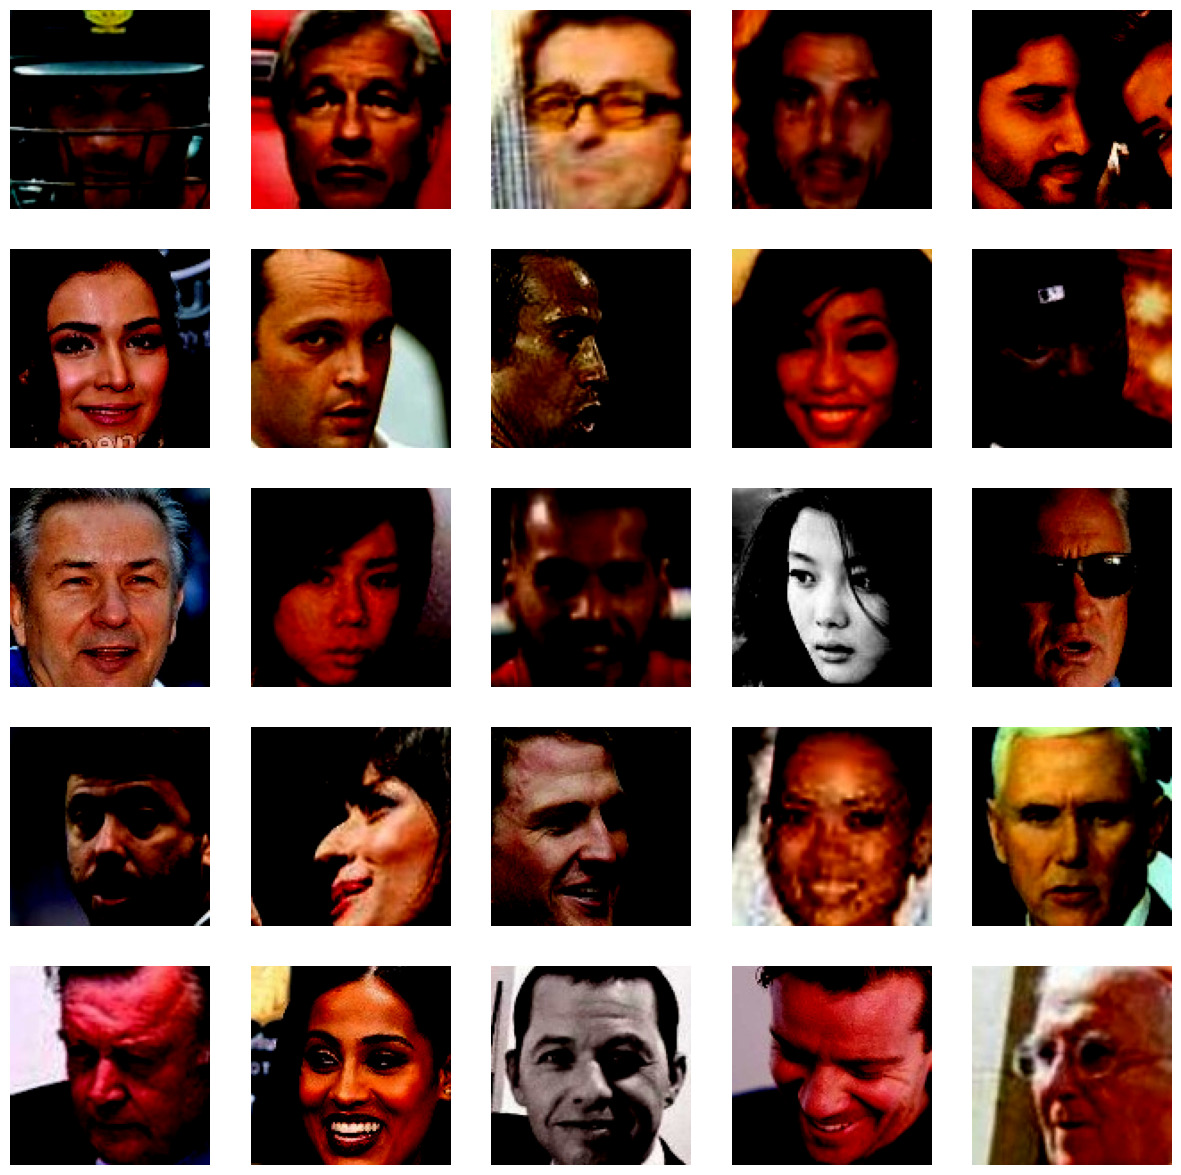

In [10]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [11]:
# TODO: Fill out the model definition below

class Network(torch.nn.Module):

    def __init__(self, num_classes=8631):
        super().__init__()

        self.backbone = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding_mode='zeros', padding=3//2),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding_mode='zeros', padding=3//2),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding_mode='zeros', padding=3//2),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),  
            torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding_mode='zeros', padding=3//2),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),  
            torch.nn.AdaptiveAvgPool2d((1, 1)),
            torch.nn.Flatten()
        )


        self.cls_layer = torch.nn.Linear(1024, num_classes)

    def forward(self, x):
            # TODO:
        feats = self.backbone(x)
        out = self.cls_layer(feats)

        return {"feats": feats, "out": out}

# Initialize your model
model = Network()
model.to(torch.device(DEVICE))
summary(model, (3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024]                --
|    └─Conv2d: 2-1                       [-1, 64, 27, 27]          9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 27, 27]          128
|    └─ReLU: 2-3                         [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 128, 14, 14]         73,856
|    └─BatchNorm2d: 2-5                  [-1, 128, 14, 14]         256
|    └─ReLU: 2-6                         [-1, 128, 14, 14]         --
|    └─Conv2d: 2-7                       [-1, 256, 7, 7]           295,168
|    └─BatchNorm2d: 2-8                  [-1, 256, 7, 7]           512
|    └─ReLU: 2-9                         [-1, 256, 7, 7]           --
|    └─Conv2d: 2-10                      [-1, 512, 4, 4]           1,180,160
|    └─BatchNorm2d: 2-11                 [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-12                        [-1, 512, 4, 4]    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024]                --
|    └─Conv2d: 2-1                       [-1, 64, 27, 27]          9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 27, 27]          128
|    └─ReLU: 2-3                         [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 128, 14, 14]         73,856
|    └─BatchNorm2d: 2-5                  [-1, 128, 14, 14]         256
|    └─ReLU: 2-6                         [-1, 128, 14, 14]         --
|    └─Conv2d: 2-7                       [-1, 256, 7, 7]           295,168
|    └─BatchNorm2d: 2-8                  [-1, 256, 7, 7]           512
|    └─ReLU: 2-9                         [-1, 256, 7, 7]           --
|    └─Conv2d: 2-10                      [-1, 512, 4, 4]           1,180,160
|    └─BatchNorm2d: 2-11                 [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-12                        [-1, 512, 4, 4]    

In [12]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss() # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer =  torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # TODO: Feel free to pick a optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)#  TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
# scaler = torch.cuda.amp.GradScaler()
scaler = None

# Metrics

In [13]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [15]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [16]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):
    model.to('mps')
    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # # forward
        # with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
        #     outputs = model(images)

        #     # Use the type of output depending on the loss function you want to use
        #     loss = criterion(outputs['out'], labels)
    
        outputs = model(images)
        # Use the type of output depending on the loss function you want to use
        loss = criterion(outputs['out'], labels)


        if scaler:
            scaler.scale(loss).backward() # This is a replacement for loss.backward()
            scaler.step(optimizer) # This is a replacement for optimizer.step()
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
            
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [17]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [18]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.mps.empty_cache()

# Verification Task

In [19]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [20]:
wandb.login(key="697b63713f31c5da1a73bcf4018263fe3c071219") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nebhailema (nebhailema-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/nebiyouhailemariam/.netrc


True

In [21]:
# Create your wandb run
run = wandb.init(
    name = "early-submission", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Checkpointing and Loading Model

In [22]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
        #  'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [23]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/20



Epoch 1/20: 
Train Cls. Acc 0.0894%	 Train Cls. Loss 8.8760	 Learning Rate 0.0099


Val Cls. Acc 0.1907%	 Val Cls. Loss 8.5276


{'ACC': np.float64(59.9), 'EER': 41.25736738715949, 'AUC': np.float64(61.56954853372494), 'TPRs': [('TPR@FPR=1e-4', np.float64(2.4439918533604885)), ('TPR@FPR=5e-4', np.float64(2.4439918533604885)), ('TPR@FPR=1e-3', np.float64(2.4439918533604885)), ('TPR@FPR=5e-3', np.float64(5.7026476578411405)), ('TPR@FPR=5e-2', np.float64(15.885947046843176))]}
Val Ret. Acc 59.9000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/20



Epoch 2/20: 
Train Cls. Acc 0.5266%	 Train Cls. Loss 8.1418	 Learning Rate 0.0098


Val Cls. Acc 1.0041%	 Val Cls. Loss 7.8033


{'ACC': np.float64(62.6), 'EER': 37.9174852651332, 'AUC': np.float64(66.767232583357), 'TPRs': [('TPR@FPR=1e-4', np.float64(2.8513238289205702)), ('TPR@FPR=5e-4', np.float64(2.8513238289205702)), ('TPR@FPR=1e-3', np.float64(2.8513238289205702)), ('TPR@FPR=5e-3', np.float64(4.480651731160896)), ('TPR@FPR=5e-2', np.float64(19.144602851323828))]}
Val Ret. Acc 62.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/20



Epoch 3/20: 
Train Cls. Acc 2.2804%	 Train Cls. Loss 7.3974	 Learning Rate 0.0095


Val Cls. Acc 3.5313%	 Val Cls. Loss 7.0400


{'ACC': np.float64(64.8), 'EER': 36.45621181262349, 'AUC': np.float64(69.45330287012992), 'TPRs': [('TPR@FPR=1e-4', np.float64(2.240325865580448)), ('TPR@FPR=5e-4', np.float64(2.240325865580448)), ('TPR@FPR=1e-3', np.float64(2.240325865580448)), ('TPR@FPR=5e-3', np.float64(5.4989816700611)), ('TPR@FPR=5e-2', np.float64(23.217922606924642))]}
Val Ret. Acc 64.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/20



Epoch 4/20: 
Train Cls. Acc 6.4062%	 Train Cls. Loss 6.6617	 Learning Rate 0.0090


Val Cls. Acc 8.4507%	 Val Cls. Loss 6.4072


{'ACC': np.float64(67.9), 'EER': 32.41650294684792, 'AUC': np.float64(73.03246251785578), 'TPRs': [('TPR@FPR=1e-4', np.float64(3.054989816700611)), ('TPR@FPR=5e-4', np.float64(3.054989816700611)), ('TPR@FPR=1e-3', np.float64(3.054989816700611)), ('TPR@FPR=5e-3', np.float64(8.146639511201629)), ('TPR@FPR=5e-2', np.float64(29.938900203665987))]}
Val Ret. Acc 67.9000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/20



Epoch 5/20: 
Train Cls. Acc 13.2307%	 Train Cls. Loss 5.9428	 Learning Rate 0.0085


Val Cls. Acc 15.2769%	 Val Cls. Loss 5.7056


{'ACC': np.float64(70.5), 'EER': 30.25540275041314, 'AUC': np.float64(74.91347196491664), 'TPRs': [('TPR@FPR=1e-4', np.float64(5.091649694501019)), ('TPR@FPR=5e-4', np.float64(5.091649694501019)), ('TPR@FPR=1e-3', np.float64(5.091649694501019)), ('TPR@FPR=5e-3', np.float64(8.146639511201629)), ('TPR@FPR=5e-2', np.float64(30.95723014256619))]}
Val Ret. Acc 70.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/20



Epoch 6/20: 
Train Cls. Acc 22.3009%	 Train Cls. Loss 5.2442	 Learning Rate 0.0079


Val Cls. Acc 23.1683%	 Val Cls. Loss 5.0918


{'ACC': np.float64(72.2), 'EER': 28.5132382892057, 'AUC': np.float64(77.83881977760795), 'TPRs': [('TPR@FPR=1e-4', np.float64(5.7026476578411405)), ('TPR@FPR=5e-4', np.float64(5.7026476578411405)), ('TPR@FPR=1e-3', np.float64(5.7026476578411405)), ('TPR@FPR=5e-3', np.float64(9.979633401221996)), ('TPR@FPR=5e-2', np.float64(33.19755600814664))]}
Val Ret. Acc 72.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/20



Epoch 7/20: 
Train Cls. Acc 32.0172%	 Train Cls. Loss 4.5801	 Learning Rate 0.0073


Val Cls. Acc 30.9263%	 Val Cls. Loss 4.5296


{'ACC': np.float64(73.1), 'EER': 27.29124236252538, 'AUC': np.float64(79.4325361417099), 'TPRs': [('TPR@FPR=1e-4', np.float64(7.3319755600814664)), ('TPR@FPR=5e-4', np.float64(7.3319755600814664)), ('TPR@FPR=1e-3', np.float64(7.3319755600814664)), ('TPR@FPR=5e-3', np.float64(10.183299389002038)), ('TPR@FPR=5e-2', np.float64(37.67820773930753))]}
Val Ret. Acc 73.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/20



Epoch 8/20: 
Train Cls. Acc 41.4456%	 Train Cls. Loss 3.9703	 Learning Rate 0.0065


Val Cls. Acc 38.2363%	 Val Cls. Loss 4.0537


{'ACC': np.float64(74.3), 'EER': 26.129666011830032, 'AUC': np.float64(80.35763587402317), 'TPRs': [('TPR@FPR=1e-4', np.float64(13.238289205702646)), ('TPR@FPR=5e-4', np.float64(13.238289205702646)), ('TPR@FPR=1e-3', np.float64(13.238289205702646)), ('TPR@FPR=5e-3', np.float64(15.478615071283095)), ('TPR@FPR=5e-2', np.float64(36.456211812627295))]}
Val Ret. Acc 74.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/20



Epoch 9/20: 
Train Cls. Acc 49.4759%	 Train Cls. Loss 3.4426	 Learning Rate 0.0058


Val Cls. Acc 44.1816%	 Val Cls. Loss 3.6242


{'ACC': np.float64(75.1), 'EER': 24.95088408655175, 'AUC': np.float64(81.11348076776876), 'TPRs': [('TPR@FPR=1e-4', np.float64(12.830957230142568)), ('TPR@FPR=5e-4', np.float64(12.830957230142568)), ('TPR@FPR=1e-3', np.float64(12.830957230142568)), ('TPR@FPR=5e-3', np.float64(13.849287169042771)), ('TPR@FPR=5e-2', np.float64(40.122199592668025))]}
Val Ret. Acc 75.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/20



Epoch 10/20: 
Train Cls. Acc 56.3546%	 Train Cls. Loss 3.0006	 Learning Rate 0.0050


Val Cls. Acc 48.6105%	 Val Cls. Loss 3.3164


{'ACC': np.float64(74.8), 'EER': 26.680244399185327, 'AUC': np.float64(80.88820777932051), 'TPRs': [('TPR@FPR=1e-4', np.float64(13.849287169042771)), ('TPR@FPR=5e-4', np.float64(13.849287169042771)), ('TPR@FPR=1e-3', np.float64(13.849287169042771)), ('TPR@FPR=5e-3', np.float64(19.551934826883908)), ('TPR@FPR=5e-2', np.float64(45.010183299389))]}
Val Ret. Acc 74.8000%
Saved epoch model
Saved best classification model

Epoch 11/20



Epoch 11/20: 
Train Cls. Acc 61.9918%	 Train Cls. Loss 2.6417	 Learning Rate 0.0042


Val Cls. Acc 52.3890%	 Val Cls. Loss 3.0493


{'ACC': np.float64(75.1), 'EER': 26.12966601175262, 'AUC': np.float64(81.59843789387762), 'TPRs': [('TPR@FPR=1e-4', np.float64(12.627291242362526)), ('TPR@FPR=5e-4', np.float64(12.627291242362526)), ('TPR@FPR=1e-3', np.float64(12.627291242362526)), ('TPR@FPR=5e-3', np.float64(17.718940936863543)), ('TPR@FPR=5e-2', np.float64(41.75152749490835))]}
Val Ret. Acc 75.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/20



Epoch 12/20: 
Train Cls. Acc 66.5024%	 Train Cls. Loss 2.3531	 Learning Rate 0.0035


Val Cls. Acc 54.8819%	 Val Cls. Loss 2.8715


{'ACC': np.float64(75.4), 'EER': 25.458248472505097, 'AUC': np.float64(82.02177505511786), 'TPRs': [('TPR@FPR=1e-4', np.float64(13.034623217922606)), ('TPR@FPR=5e-4', np.float64(13.034623217922606)), ('TPR@FPR=1e-3', np.float64(13.034623217922606)), ('TPR@FPR=5e-3', np.float64(18.126272912423623)), ('TPR@FPR=5e-2', np.float64(43.17718940936864))]}
Val Ret. Acc 75.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/20



Epoch 13/20: 
Train Cls. Acc 70.2076%	 Train Cls. Loss 2.1250	 Learning Rate 0.0027


Val Cls. Acc 56.8373%	 Val Cls. Loss 2.7434


{'ACC': np.float64(75.8), 'EER': 25.736738703359872, 'AUC': np.float64(82.5463450157851), 'TPRs': [('TPR@FPR=1e-4', np.float64(11.201629327902241)), ('TPR@FPR=5e-4', np.float64(11.201629327902241)), ('TPR@FPR=1e-3', np.float64(11.201629327902241)), ('TPR@FPR=5e-3', np.float64(12.627291242362526)), ('TPR@FPR=5e-2', np.float64(47.04684317718941))]}
Val Ret. Acc 75.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/20



Epoch 14/20: 
Train Cls. Acc 73.2183%	 Train Cls. Loss 1.9447	 Learning Rate 0.0021


Val Cls. Acc 58.4112%	 Val Cls. Loss 2.6326


{'ACC': np.float64(75.1), 'EER': 25.45824847250504, 'AUC': np.float64(82.53954281187103), 'TPRs': [('TPR@FPR=1e-4', np.float64(9.775967413441954)), ('TPR@FPR=5e-4', np.float64(9.775967413441954)), ('TPR@FPR=1e-3', np.float64(9.775967413441954)), ('TPR@FPR=5e-3', np.float64(15.885947046843176)), ('TPR@FPR=5e-2', np.float64(44.602851323828915))]}
Val Ret. Acc 75.1000%
Saved epoch model
Saved best classification model

Epoch 15/20



Epoch 15/20: 
Train Cls. Acc 75.6072%	 Train Cls. Loss 1.8043	 Learning Rate 0.0015


Val Cls. Acc 59.7196%	 Val Cls. Loss 2.5655


{'ACC': np.float64(75.7), 'EER': 24.95088408624899, 'AUC': np.float64(82.55034631220515), 'TPRs': [('TPR@FPR=1e-4', np.float64(10.590631364562118)), ('TPR@FPR=5e-4', np.float64(10.590631364562118)), ('TPR@FPR=1e-3', np.float64(10.590631364562118)), ('TPR@FPR=5e-3', np.float64(16.90427698574338)), ('TPR@FPR=5e-2', np.float64(47.25050916496945))]}
Val Ret. Acc 75.7000%
Saved epoch model
Saved best classification model

Epoch 16/20



Epoch 16/20: 
Train Cls. Acc 77.4805%	 Train Cls. Loss 1.6973	 Learning Rate 0.0010


Val Cls. Acc 60.3770%	 Val Cls. Loss 2.5025


{'ACC': np.float64(76.2), 'EER': 25.343811394833928, 'AUC': np.float64(82.734405947527), 'TPRs': [('TPR@FPR=1e-4', np.float64(12.627291242362526)), ('TPR@FPR=5e-4', np.float64(12.627291242362526)), ('TPR@FPR=1e-3', np.float64(12.627291242362526)), ('TPR@FPR=5e-3', np.float64(15.071283095723015)), ('TPR@FPR=5e-2', np.float64(45.621181262729124))]}
Val Ret. Acc 76.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 17/20



Epoch 17/20: 
Train Cls. Acc 78.9188%	 Train Cls. Loss 1.6190	 Learning Rate 0.0005


Val Cls. Acc 60.7181%	 Val Cls. Loss 2.4772


{'ACC': np.float64(75.1), 'EER': 25.54027504912347, 'AUC': np.float64(82.55594812719322), 'TPRs': [('TPR@FPR=1e-4', np.float64(12.219959266802444)), ('TPR@FPR=5e-4', np.float64(12.219959266802444)), ('TPR@FPR=1e-3', np.float64(12.219959266802444)), ('TPR@FPR=5e-3', np.float64(14.663951120162933)), ('TPR@FPR=5e-2', np.float64(45.824847250509166))]}
Val Ret. Acc 75.1000%
Saved epoch model
Saved best classification model

Epoch 18/20



Epoch 18/20: 
Train Cls. Acc 79.9529%	 Train Cls. Loss 1.5650	 Learning Rate 0.0002


Val Cls. Acc 61.1684%	 Val Cls. Loss 2.4525


{'ACC': np.float64(75.6), 'EER': 24.84725050917963, 'AUC': np.float64(82.71079829864875), 'TPRs': [('TPR@FPR=1e-4', np.float64(12.016293279022404)), ('TPR@FPR=5e-4', np.float64(12.016293279022404)), ('TPR@FPR=1e-3', np.float64(12.016293279022404)), ('TPR@FPR=5e-3', np.float64(15.478615071283095)), ('TPR@FPR=5e-2', np.float64(47.45417515274949))]}
Val Ret. Acc 75.6000%
Saved epoch model
Saved best classification model

Epoch 19/20



Epoch 19/20: 
Train Cls. Acc 80.5814%	 Train Cls. Loss 1.5312	 Learning Rate 0.0001


Val Cls. Acc 61.2994%	 Val Cls. Loss 2.4460


{'ACC': np.float64(75.4), 'EER': 26.272912423625222, 'AUC': np.float64(82.55694845129821), 'TPRs': [('TPR@FPR=1e-4', np.float64(13.034623217922606)), ('TPR@FPR=5e-4', np.float64(13.034623217922606)), ('TPR@FPR=1e-3', np.float64(13.034623217922606)), ('TPR@FPR=5e-3', np.float64(15.885947046843176)), ('TPR@FPR=5e-2', np.float64(47.657841140529534))]}
Val Ret. Acc 75.4000%
Saved epoch model
Saved best classification model

Epoch 20/20



Epoch 20/20: 
Train Cls. Acc 80.9661%	 Train Cls. Loss 1.5141	 Learning Rate 0.0000


Val Cls. Acc 61.3155%	 Val Cls. Loss 2.4385


{'ACC': np.float64(75.5), 'EER': 25.933202357586683, 'AUC': np.float64(82.55914916432926), 'TPRs': [('TPR@FPR=1e-4', np.float64(12.627291242362526)), ('TPR@FPR=5e-4', np.float64(12.627291242362526)), ('TPR@FPR=1e-3', np.float64(12.627291242362526)), ('TPR@FPR=5e-3', np.float64(15.071283095723015)), ('TPR@FPR=5e-2', np.float64(47.04684317718941))]}
Val Ret. Acc 75.5000%
Saved epoch model
Saved best classification model


In [48]:
next(model.parameters()).is_mps

False

# Testing and Kaggle Submission (Verification)

In [76]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [82]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

# EER was 25——did not cross the low-cutoff